In [14]:
import pickle as pkl

In [15]:
filename = "sim_results/market-marl-nash-3-04-27-2022-04-34-1590_results.pkl"

with open(filename, 'rb') as f:
    res = pkl.load(f)


In [16]:
l = list(dir(res))

In [17]:
import numpy as np
import seaborn as sns

In [18]:
dir(res)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'avg_epoch_rewards',
 'avg_epoch_rewards_agent',
 'avg_epoch_rewards_sum',
 'episode_rewards',
 'losses',
 'losses_eps',
 'losses_nash',
 'marl_params',
 'mdp_env',
 'sna_policy_dict_iter',
 'state_tracker_epoch']

In [19]:
import pandas as pd

sns.set_theme(style="darkgrid")
data_losses = {"Q Function Loss": res.losses, "Epsilon Function Loss": res.losses_eps, "Nash Net Loss": res.losses_nash}
data_losses_df = pd.DataFrame(data=data_losses)
# sns.lineplot(data=data_losses_df)

In [26]:
res.marl_params

{'epochs': 90,
 'explore_epsilon': 0.05,
 'max_steps': 30,
 'sync_freq': 10,
 'mem_size': 101333,
 'turbo_max_evals': 13,
 'turbo_batch_size': 13,
 'turbo_n_init': 13}

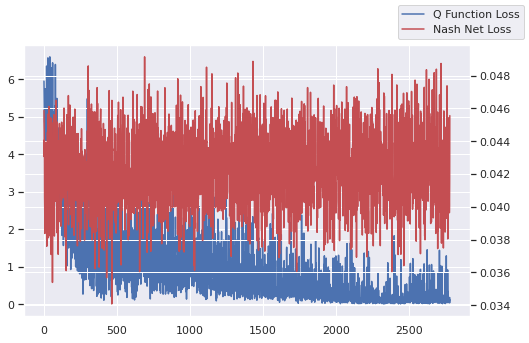

In [20]:
# import matplotlib.pyplot as plt

ax = data_losses_df.plot(y="Q Function Loss", legend=False, figsize=(8, 5))
ax2 = ax.twinx()

data_losses_df.plot(y="Nash Net Loss", ax=ax2, legend=False, color="r")
ax.figure.legend()

# data_losses_df.plot(y="Epsilon Function Loss", ax=ax2, legend=False, color="r")
# ax.figure.legend()


In [21]:
# import matplotlib.pyplot as plt
# sns.lineplot(data=res.losses, color="b", legend="auto")
# ax2 = plt.twinx()
# sns.lineplot(data=res.losses_eps, color="g", ax=ax2)


In [22]:
# Plot rewards

data_rewards = {"Average Agent Reward": res.avg_epoch_rewards, "Average Reward for Agent 0": res.avg_epoch_rewards_agent}
data_rewards_df = pd.DataFrame(data=data_rewards)

<AxesSubplot:>

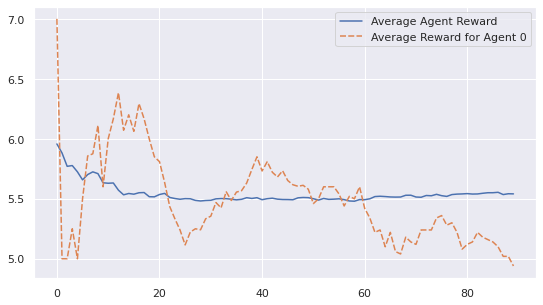

In [23]:
sns.set(rc={'figure.figsize':(9, 5)})
sns.lineplot(data=data_rewards_df)

In [24]:
res.state_tracker


AttributeError: 'ResultObj' object has no attribute 'state_tracker'

In [ ]:
state_key = [0.0, 0.0, 0.0, 8.0]

res.sna_policy_dict_iter[repr(state_key)][0]

In [ ]:
max_p = 0
agent_id = 0
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)

0.29256391912373747
0.04729018146970276
0.23390691008516115
0.13406257622945048
0.9454341711222074
0.9231062038247865
0.5498794413040651
0.6336318376618623
0.902526343526543
0.5706366424799063
4


In [ ]:
max_p = 0
agent_id = 1
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.08690369635134479
0.4881284209955355
0.09624667156345076
0.33369447176782846
0.8233315589098196
0.5556520321431938
0.13187221280279798
0.7951976062801666
0.07205333332401664
0.15643796439927526
4


In [ ]:
max_p = 0
agent_id = 2
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.9448579358289002
0.032040132611964714
0.4809564755195185
0.7337314147870997
0.9051270509154368
0.0061314603073509555
0.536328006583276
0.7885945494485362
0.7175736846282129
0.22592140791788273
0


In [ ]:
res.state_tracker

[3.3333333333333335]